In [ ]:
!pip install langgraph

In [ ]:
!pip install langchain_openai

In [ ]:
import os
from typing import List,TypedDict
from langgraph.graph import StateGraph,END
from langchain_openai import ChatOpenAI,OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document


In [ ]:
import os 
from dotenv import load_dotenv
load_dotenv()
os.getenv("OPENAI_API_KEY")


In [ ]:
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
llm=ChatOpenAI(model_name="gpt-4",temperature=0)
embeddings=OpenAIEmbeddings(model="text-embedding-3-small")
llm

## State definiton

In [ ]:
class AgentState(TypedDict):
    question: str
    documents: List[Document]
    answer: str
    needs_retrieval: bool

In [ ]:
!pip install faiss-cpu

In [ ]:
sample_texts = [
    "LangGraph is a library for building stateful, multi-actor applications with LLMs. It extends LangChain with the ability to coordinate multiple chains across multiple steps of computation in a cyclic manner.",
    "RAG (Retrieval-Augmented Generation) is a technique that combines information retrieval with text generation. It retrieves relevant documents and uses them to provide context for generating more accurate responses.",
    "Vector databases store high-dimensional vectors and enable efficient similarity search. They are commonly used in RAG systems to find relevant documents based on semantic similarity.",
    "Agentic systems are AI systems that can take actions, make decisions, and interact with their environment autonomously. They often use planning and reasoning capabilities."
]

documents=[Document(page_content=text) for text in sample_texts]
vector_store=FAISS.from_documents(documents,embeddings)
retriever=vector_store.as_retriever(search_type="similarity",search_kwargs={"k":3})
q=retriever.invoke("Explain LangGraph and RAG")
q[0].page_content

## agents function

In [ ]:
def decide_retrieval(state: AgentState) ->AgentState:
   """Decides if need to documents  based on question""" 
   question =state["question"]
   retrieval_keywords=["who","what","when","where","why","explain","define","describe","tell me about"]
   needs_retrieval=any(keyword in question.lower() for keyword in retrieval_keywords)
   return {**state,"needs_retrieval":needs_retrieval}

In [ ]:
def retrive_documents(state: AgentState) ->AgentState:
    """Retrieves documents based on user input"""
    user_input=state["question"]
    documents=retriever.invoke(user_input)
    return {**state,"retrieved_docs":documents}

In [ ]:
def generate_answer(state: AgentState) ->AgentState:
    """Generates answer based on user input and retrieved documents"""
    question=state["question"]
    documents= state.get("documents",[])
    
    if documents:
        context="\n".join([doc.page_content for doc in documents])
        prompt=f"Using the following context:\n{context}\nAnswer the question: {question}"
        
    else:
        prompt=f"anser the following question:{question}"
        
    response=llm.invoke(prompt)
    answer=response.content
    return {**state,"answer":answer}
    


## conditonal logic

In [ ]:
def should_retrieve(state: AgentState) -> str:
    """
    Determine the next step based on retrieval decision
    """
    if state["needs_retrieval"]:
        return "retrieve"
    else:
        return "generate"

## build the graph

In [ ]:
## create the state graph
workflow = StateGraph(AgentState)

# Correct order: add_node("node_name", function)
workflow.add_node("decide", decide_retrieval)
workflow.add_node("retrieve", retrive_documents)
workflow.add_node("generate", generate_answer)

## set entry point
workflow.set_entry_point("decide")

## add conditional edges
workflow.add_conditional_edges(
    "decide",
    should_retrieve,
    {
        "retrieve": "retrieve",
        "generate": "generate"
    }
)

## add edges
workflow.add_edge("retrieve", "generate")
workflow.add_edge("generate", END)

# build the graph
app = workflow.compile()


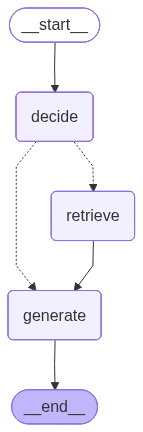

## test agetic rag

In [ ]:
def ask_question(question: str):
    """
    Helper function to ask a question and get an answer
    """
    initial_state = {
        "question": question,
        "documents": [],
        "answer": "",
        "needs_retrieval": False
    }
    
    result = app.invoke(initial_state)
    return result
    

In [ ]:
# Test with a question that should trigger retrieval
question1 = "What is LangGraph?"
result1 = ask_question(question1)
result1

In [ ]:
# Test with another question
question2 = "How does RAG work?"
result2 = ask_question(question2)

print(f"Question: {question2}")
print(f"Retrieved documents: {len(result2['documents'])}")
print(f"Answer: {result2['answer']}")
print("\n" + "="*50 + "\n")